# Text classification with an RNN

### Import

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
tfds.disable_progress_bar()

### Fonts

In [2]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Parameters

In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 1000

### Helper function to plot graphs:

In [4]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

### Get Data
The IMDB large movie review dataset is a binary classification dataset. All the reviews have either a positive or negative sentiment. We are using tensorflow_datasets to download the dataset.

In [28]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Create the text encoder
The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the TextVectorization layer. This layer has many capabilities, but this tutorial sticks to the default behavior. Create the layer, and pass the dataset's text to the layer's .adapt method

In [29]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

### Look at vocabulary

In [41]:
vocab = np.array(encoder.get_vocabulary())
vocab[:40]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be',
       'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so',
       'like'], dtype='<U14')

### Check Encoder

In [42]:
for example, label in train_dataset.take(1):
    encoded_example = encoder(example)[:3].numpy()
    print(encoded_example)

[[ 51  10   1 ...   0   0   0]
 [149  11 194 ...   0   0   0]
 [  1   1  13 ...   0   0   0]]


### Encoding -> Decoding

In [44]:
for n in range(1):
    print('-> Original')
    print(example[n].numpy())
    print(' ')
    print('-> Encoded to Decoded')
    print(" ".join(vocab[encoded_example[n]]))
    print()

-> Original
b'When I ordered this from Blockbuster\'s website I had no idea that it would be as terrible as it was. Who knows? Maybe I\'d forgotten to take my ADD meds that day. I do know that from the moment the cast drove up in their station wagon, donned in their late 70\'s-style wide collars, bell-bottoms and feathered hair, I knew that this misplaced gem of the disco era was glory bound for the dumpster.<br /><br />The first foretelling of just how bad things were to be was the narration at the beginning, trying to explain what cosmic forces were at play to wreak havoc upon the universe, forcing polyester and porno-quality music on the would-be viewer. From the opening scene with the poorly-done effects to the "monsters" from another world and then the house which jumps from universe to universe was as achingly painful as watching an elementary school production of \'The Vagina Monologues\'.<br /><br />Throughout the film, the sure sign something was about to happen was when a sma

## Create the model
This model can be build as a tf.keras.Sequential. The first layer is the encoder, which converts the text to a sequence of token indices. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors. This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep. The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end. After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.

In [39]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

### Compile the model

In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [47]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

### Store

In [48]:
model.save('../../models/rnn_text_classification');

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x12e835e50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x12e835e50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x12e835e50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-09-13 20:34:56.783942: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unmatched ')' (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unmatched ')' (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unmatched ')' (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('saveables', 'tensor_structure'), but source function had ('saveables',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('saveables', 'tensor_structure'), but source function had ('saveables',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('saveables', 'tensor_structure'), but source function had ('saveables',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function _trace_resource_initializers.<locals>._wrap_obj_initializer.<locals>.<lambda> at 0x1576c5b80>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function _trace_resource_initializers.<locals>._wrap_obj_initializer.<locals>.<lambda> at 0x1576c5b80>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function _trace_resource_initializers.<locals>._wrap_obj_initializer.<locals>.<lambda> at 0x1576c5b80>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _trace_resource_initializers.<locals>._wrap_obj_initializer.<locals>.<lambda> at 0x131a47e50>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function _trace_resource_initializers.<locals>._wrap_obj_initializer.<locals>.<lambda> at 0x131a47e50>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function _trace_resource_initializers.<locals>._wrap_obj_initializer.<locals>.<lambda> at 0x131a47e50>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: ../../models/rnn_text_classification/assets


INFO:tensorflow:Assets written to: ../../models/rnn_text_classification/assets


### Predict and Plot the Results

In [49]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],'k',linewidth=2)
plt.plot(history.history['val_accuracy'],'r',linewidth=2)
plt.xlabel('Epoch',**csfont,fontsize=24)
plt.ylabel('Accuracy',**csfont,fontsize=24)
plt.xticks(np.linspace(0,10,11),np.linspace(0,10,11),**csfont,fontsize=16)
plt.yticks(np.linspace(0,1,11),np.linspace(0,1,11),**csfont,fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],'k',linewidth=2)
plt.plot(history.history['val_loss'],'r',linewidth=2)
plt.xlabel('Epoch',**csfont,fontsize=24)
plt.ylabel('Loss',**csfont,fontsize=24)
plt.xticks(np.linspace(0,10,11),np.linspace(0,10,11),**csfont,fontsize=16)
plt.yticks(np.linspace(0,1,11),np.linspace(0,1,11),**csfont,fontsize=16)
plt.savefig('../../assets/matplotlib/26-text-classification-with-RNNs.png', dpi=300,bbox_inches="tight")    

SyntaxError: invalid syntax (459403811.py, line 3)

### Run a prediction on a new sentence

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 71s 145ms/step - loss: 0.6166 - accuracy: 0.6006 - val_loss: 0.4270 - val_accuracy: 0.8125
Epoch 2/10
391/391 [==============================] - 52s 131ms/step - loss: 0.3837 - accuracy: 0.8346 - val_loss: 0.3605 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 54s 134ms/step - loss: 0.3345 - accuracy: 0.8572 - val_loss: 0.3385 - val_accuracy: 0.8396
Epoch 4/10
391/391 [==============================] - 52s 130ms/step - loss: 0.3204 - accuracy: 0.8643 - val_loss: 0.3282 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 52s 131ms/step - loss: 0.3103 - accuracy: 0.8678 - val_loss: 0.3253 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 52s 130ms/step - loss: 0.3068 - accuracy: 0.8693 - val_loss: 0.3233 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 52s 131ms/step - loss: 0.3034 - accuracy: 0.8683 - val_loss: 0.3234 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 24s 61ms/step - loss: 0.3354 - accuracy: 0.8635
Test Loss: 0.33541229367256165
Test Accuracy: 0.8635200262069702


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8224874]]


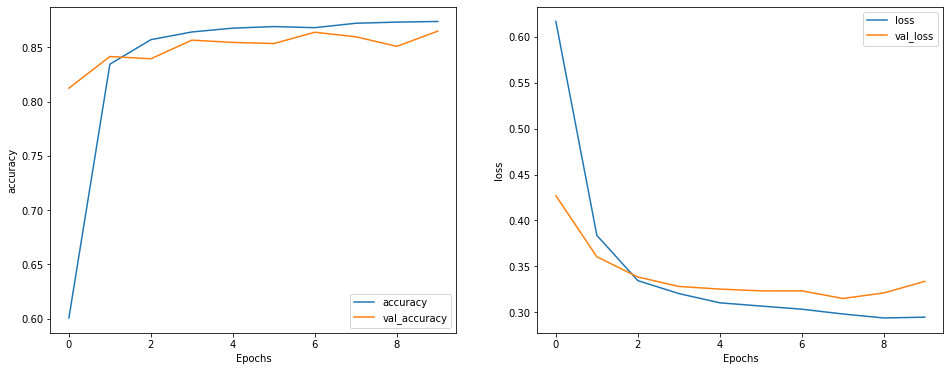

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
